# DS50 Rating Predictor

In [100]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp

import math

import nltk
nltk.download('punkt')

sns.set_theme(style="darkgrid")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
import mysql.connector

In [102]:
#Import the review dataset
connection = mysql.connector.connect(
            host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
            database='ds50',
            user='ds50',
            password='AVNS_4ybSd0CoPKnCL5F',
            port = '25060'
)

for i in range(5):

    query = f"""
        SELECT
            *
        FROM
            REVIEW
        WHERE
            rating = {i+1}
        AND
            review_text != ''
        LIMIT
            2000
    """

    if connection.is_connected():
        if not i:
            df = pd.read_sql(query, connection)
        else:
            new_df = pd.read_sql(query, connection)
            df = pd.concat([df, new_df])

print(df.shape)
df.head()

(10000, 9)


,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,0000f2fa08114079d9d7215bc5e754d2,155648,24817626,1,I reread To Kill a Mockingbird prior to readin...,2015-04-25 11:36:35,2016-08-13 07:00:00,1,0
1,00086204557677e4f3c5225096510623,111795,17332969,1,"This was so bad, seriously I finished it becau...",2014-11-15 05:45:11,2015-02-15 08:00:00,0,0
2,00148dbc65dcac4ae7063297d5c31d87,432685,15745753,1,Probably the worst book I have read in my life...,2016-02-22 09:42:42,2016-02-22 08:00:00,1,0
3,00165a73ba617b652f0e58628f159155,492,16085517,1,This book takes a lot of interesting events/ac...,2013-08-02 19:20:13,2013-08-02 07:00:00,0,0
4,0016cbf252b1633d8444158cd9ee47d2,10309,16068905,1,I put off reading the last few chapters for so...,2013-04-16 09:20:26,NaT,4,1


In [103]:
df = df[['book_id','rating','review_text']].rename(columns={'review_text':'review'})
df.head()

,book_id,rating,review
0,24817626,1,I reread To Kill a Mockingbird prior to readin...
1,17332969,1,"This was so bad, seriously I finished it becau..."
2,15745753,1,Probably the worst book I have read in my life...
3,16085517,1,This book takes a lot of interesting events/ac...
4,16068905,1,I put off reading the last few chapters for so...


In [104]:
from deep_translator import GoogleTranslator

def translateWords(words, lang):
    translations = []
    gl = GoogleTranslator(source=lang, target='en')
    for word in words:
        try:
            translation = gl.translate(word)
            translations.append(translation)
        except:
            pass
    return translations

def translateText(text, lang):
    gl = GoogleTranslator(source=lang, target='en')
    try:
        if len(text) < 5000:
            translation = gl.translate(text)
        else:
            translation = gl.translate(text[:4999])
        return translation
    except:
        print(text)
        return text

In [105]:
from langdetect import detect
from tqdm.notebook import tqdm_notebook

translated = []
to_drop = []

for index, row in tqdm_notebook(df.iterrows()):
    try:
        lang = detect(row['review'])
    except:
        to_drop.append(index)
        continue
    if lang != 'en':
        translated.append(translateText(row['review'], lang))
    else:
        translated.append(row['review'])

In [106]:
df.drop(to_drop, inplace=True)
df['translated'] = translated
df.head()

,book_id,rating,review,translated
0,24817626,1,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...
1,17332969,1,"This was so bad, seriously I finished it becau...","This was so bad, seriously I finished it becau..."
2,15745753,1,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...
3,16085517,1,This book takes a lot of interesting events/ac...,This book takes a lot of interesting events/ac...
4,16068905,1,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...


In [107]:
import string

def remove_punct(text):
    no_punct_text = "".join([char for char in text if char not in string.punctuation])
    return no_punct_text

In [108]:
df['nopunct'] = df['translated'].apply(lambda x: remove_punct(x))
df.head()

,book_id,rating,review,translated,nopunct
0,24817626,1,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...
1,17332969,1,"This was so bad, seriously I finished it becau...","This was so bad, seriously I finished it becau...",This was so bad seriously I finished it becaus...
2,15745753,1,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...
3,16085517,1,This book takes a lot of interesting events/ac...,This book takes a lot of interesting events/ac...,This book takes a lot of interesting eventsact...
4,16068905,1,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...


In [109]:
df['tokenized'] = df['nopunct'].apply(lambda x: nltk.word_tokenize(str.lower(x)))
df.head()

,book_id,rating,review,translated,nopunct,tokenized
0,24817626,1,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,"[i, reread, to, kill, a, mockingbird, prior, t..."
1,17332969,1,"This was so bad, seriously I finished it becau...","This was so bad, seriously I finished it becau...",This was so bad seriously I finished it becaus...,"[this, was, so, bad, seriously, i, finished, i..."
2,15745753,1,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,"[probably, the, worst, book, i, have, read, in..."
3,16085517,1,This book takes a lot of interesting events/ac...,This book takes a lot of interesting events/ac...,This book takes a lot of interesting eventsact...,"[this, book, takes, a, lot, of, interesting, e..."
4,16068905,1,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,"[i, put, off, reading, the, last, few, chapter..."


In [110]:
import enchant

dic = enchant.Dict('en_US')

def remove_misspelled_words(words):
    well_spelled = []
    for word in words:
        if dic.check(word):
            well_spelled.append(word)
        elif word in [remove_punct(sugg) for sugg in dic.suggest(word)[10:]]:
            well_spelled.append(word)
        else:
            well_spelled.append('OOV')
    return well_spelled

In [111]:
from tqdm.notebook import tqdm_notebook

well_spelled = []
for document in tqdm_notebook(df['tokenized'], desc='Remove misspelled words'):
    well_spelled.append(remove_misspelled_words(document))

df['well_spelled'] = well_spelled
df[['tokenized','well_spelled']].head()

,tokenized,well_spelled
0,"[i, reread, to, kill, a, mockingbird, prior, t...","[i, reread, to, kill, a, mockingbird, prior, t..."
1,"[this, was, so, bad, seriously, i, finished, i...","[this, was, so, bad, seriously, i, finished, i..."
2,"[probably, the, worst, book, i, have, read, in...","[probably, the, worst, book, i, have, read, in..."
3,"[this, book, takes, a, lot, of, interesting, e...","[this, book, takes, a, lot, of, interesting, O..."
4,"[i, put, off, reading, the, last, few, chapter...","[i, put, off, reading, the, last, few, chapter..."


In [112]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(words):
    return [word for word in words if word not in stop_words]

In [113]:
no_stopwords = []
for document in tqdm_notebook(df['well_spelled'], desc='Remove stopwords'):
    no_stopwords.append(remove_stopwords(document))

df['no_stopwords'] = no_stopwords
df[['well_spelled','no_stopwords']].head()

,well_spelled,no_stopwords
0,"[i, reread, to, kill, a, mockingbird, prior, t...","[reread, kill, mockingbird, prior, reading, go..."
1,"[this, was, so, bad, seriously, i, finished, i...","[bad, seriously, finished, OOV, OOV, OOV, good..."
2,"[probably, the, worst, book, i, have, read, in...","[probably, worst, book, read, life, ya, romant..."
3,"[this, book, takes, a, lot, of, interesting, O...","[book, takes, lot, interesting, OOV, renders, ..."
4,"[i, put, off, reading, the, last, few, chapter...","[put, reading, last, chapters, long, OOV, want..."


In [114]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

def lemmatize(words):
    lemmatized = []
    lemmatizer = WordNetLemmatizer()
    for word in words:
        lem_word = lemmatizer.lemmatize(word)
        lemmatized.append(lem_word)
    return lemmatized

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [115]:
df['lemmatized'] = df['no_stopwords'].apply(lambda x: lemmatize(x))
df.head()

,book_id,rating,review,translated,nopunct,tokenized,well_spelled,no_stopwords,lemmatized
0,24817626,1,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,"[i, reread, to, kill, a, mockingbird, prior, t...","[i, reread, to, kill, a, mockingbird, prior, t...","[reread, kill, mockingbird, prior, reading, go...","[reread, kill, mockingbird, prior, reading, go..."
1,17332969,1,"This was so bad, seriously I finished it becau...","This was so bad, seriously I finished it becau...",This was so bad seriously I finished it becaus...,"[this, was, so, bad, seriously, i, finished, i...","[this, was, so, bad, seriously, i, finished, i...","[bad, seriously, finished, OOV, OOV, OOV, good...","[bad, seriously, finished, OOV, OOV, OOV, good..."
2,15745753,1,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,"[probably, the, worst, book, i, have, read, in...","[probably, the, worst, book, i, have, read, in...","[probably, worst, book, read, life, ya, romant...","[probably, worst, book, read, life, ya, romant..."
3,16085517,1,This book takes a lot of interesting events/ac...,This book takes a lot of interesting events/ac...,This book takes a lot of interesting eventsact...,"[this, book, takes, a, lot, of, interesting, e...","[this, book, takes, a, lot, of, interesting, O...","[book, takes, lot, interesting, OOV, renders, ...","[book, take, lot, interesting, OOV, render, sl..."
4,16068905,1,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,"[i, put, off, reading, the, last, few, chapter...","[i, put, off, reading, the, last, few, chapter...","[put, reading, last, chapters, long, OOV, want...","[put, reading, last, chapter, long, OOV, want,..."


In [116]:
#Save the data processed in a csv (since processing is time consuming)
df.to_csv('data/sample/nlp_book_reviews.csv', index=False)

C:\Users\benja\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating', ylabel='count'>

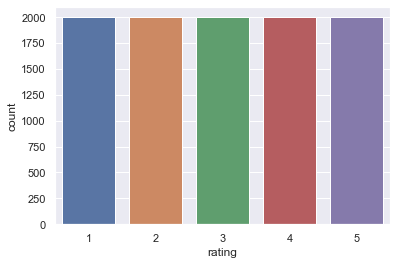

In [117]:
sns.countplot(df['rating'])

## ML Models Buidling

In [118]:
!pip install xgboost

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score

In [119]:
df = pd.read_csv('data/sample/nlp_book_reviews.csv')

import ast

for col in ['tokenized','well_spelled','no_stopwords','lemmatized']:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x))

df.head()

,book_id,rating,review,translated,nopunct,tokenized,well_spelled,no_stopwords,lemmatized
0,24817626,1,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,I reread To Kill a Mockingbird prior to readin...,"[i, reread, to, kill, a, mockingbird, prior, t...","[i, reread, to, kill, a, mockingbird, prior, t...","[reread, kill, mockingbird, prior, reading, go...","[reread, kill, mockingbird, prior, reading, go..."
1,17332969,1,"This was so bad, seriously I finished it becau...","This was so bad, seriously I finished it becau...",This was so bad seriously I finished it becaus...,"[this, was, so, bad, seriously, i, finished, i...","[this, was, so, bad, seriously, i, finished, i...","[bad, seriously, finished, OOV, OOV, OOV, good...","[bad, seriously, finished, OOV, OOV, OOV, good..."
2,15745753,1,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,Probably the worst book I have read in my life...,"[probably, the, worst, book, i, have, read, in...","[probably, the, worst, book, i, have, read, in...","[probably, worst, book, read, life, ya, romant...","[probably, worst, book, read, life, ya, romant..."
3,16085517,1,This book takes a lot of interesting events/ac...,This book takes a lot of interesting events/ac...,This book takes a lot of interesting eventsact...,"[this, book, takes, a, lot, of, interesting, e...","[this, book, takes, a, lot, of, interesting, O...","[book, takes, lot, interesting, OOV, renders, ...","[book, take, lot, interesting, OOV, render, sl..."
4,16068905,1,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,I put off reading the last few chapters for so...,"[i, put, off, reading, the, last, few, chapter...","[i, put, off, reading, the, last, few, chapter...","[put, reading, last, chapters, long, OOV, want...","[put, reading, last, chapter, long, OOV, want,..."


In [120]:
df['clean_document'] = df['lemmatized'].apply(lambda x : " ".join(list(x)))
df['clean_document'].head()

0    reread kill mockingbird prior reading go set w...
1    bad seriously finished OOV OOV OOV good thing ...
2    probably worst book read life ya romantic nove...
3    book take lot interesting OOV render slight du...
4    put reading last chapter long OOV want end alm...
Name: clean_document, dtype: object

In [121]:
tfidf = TfidfVectorizer(ngram_range=(1,1))
X = tfidf.fit_transform(df['clean_document'])


X_unigram = X.toarray()
Y = df['rating']

In [122]:
X_unigram.shape[1]

20450

In [134]:
x_train, x_test, y_train, y_test = train_test_split(X_unigram, Y, test_size=0.2, random_state=1)

              precision    recall  f1-score   support

           1       0.64      0.59      0.61       416
           2       0.38      0.50      0.43       398
           3       0.37      0.39      0.38       388
           4       0.43      0.26      0.33       425
           5       0.52      0.58      0.55       373

    accuracy                           0.46      2000
   macro avg       0.47      0.47      0.46      2000
weighted avg       0.47      0.46      0.46      2000



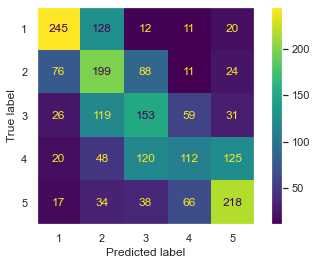

In [135]:
model = MultinomialNB()
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
CM = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3,4,5])
CM.plot()
plt.grid(False)
plt.show()

The current accuracy looks pretty bad, however if we look at the confusion matrix, we can see that the prediction is often pretty close from the real result (+ or - 1).\
-> Let's calculate an accuracy that isen't sensitive to a difference of 1.

In [136]:
accuracy = 0

for i in range(5):
    for j in range(5):
        if abs(i-j) < 2:
            accuracy += cm[i][j]

accuracy = accuracy/cm.sum()

print("Better accuracy metric : "+str(accuracy))

Better accuracy metric : 0.854
